NHITS Forecasting for optiver dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')
main_path = "drive/MyDrive/optiver-trading-at-the-close"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install neuralforecast

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [5]:
df = pd.read_csv(main_path + "/train.csv")

In [ ]:
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [6]:
#new_df = df[["stock_id", "date_id", "time_id", "target"]]
new_df = df.drop(columns=['row_id'])
new_df = new_df.rename(columns={'stock_id': 'unique_id'})
new_df = new_df.rename(columns={'time_id': 'ds'})
new_df = new_df.rename(columns={'target': 'y'})
new_df.dropna(inplace=True)

In [ ]:
new_df.head()

,unique_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,y,ds
5730,0,0,300,0.00,0,1.000241,26670118.88,1.000241,1.000241,1.000026,19319.31,1.000241,16149.55,1.000143,-10.039806,30
5731,1,0,300,242332.96,-1,1.000073,3242054.27,0.981974,0.994490,0.999544,43205.40,1.000308,2042.76,1.000273,-1.329780,30
5732,2,0,300,0.00,0,1.000193,4671376.00,1.000193,1.000193,0.999035,18971.00,1.001036,59688.26,0.999518,14.009476,30
5733,3,0,300,2914730.16,1,0.999870,41057776.66,1.003870,1.002279,0.999827,25569.50,1.000042,37897.50,0.999914,-4.339814,30
5734,4,0,300,3396923.02,1,0.998496,38356174.88,1.007894,1.007894,0.998357,14446.00,0.998703,2601.18,0.998650,10.850430,30


In [7]:
unique_stock = new_df['unique_id'].unique()
unique_stock

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  70,  71,  72,  73,  75,  76,  77,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  90,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 151, 152,
       154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 19

In [7]:
new_df[new_df['unique_id'] == 1]['ds'].unique()

array([   30,    31,    32, ..., 26452, 26453, 26454])

In [ ]:
for i in unique_values:
  print(i)

In [8]:
from sklearn.metrics import mean_absolute_error
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS, RNN, NBEATS

In [9]:
%%capture
horizon = 1

models = [NBEATS(h=horizon,                   # Forecast horizon
                input_size=15 * horizon,      # Length of input sequence
                max_steps=30),              # Number of steps to train
          NHITS(h=horizon,                   # Forecast horizon
                input_size=15 * horizon,      # Length of input sequence
                max_steps=30,               # Number of steps to train
                n_freq_downsample=[2, 1, 1]) # Downsampling factors for each stack output
          ]

models = [NHITS(h=horizon,                   # Forecast horizon
                input_size= 15 * horizon,      # Length of input sequence
                max_steps=30,               # Number of steps to train
                n_freq_downsample=[2, 1, 1],
                start_padding_enabled=True) # Downsampling factors for each stack output
          ]

nf = NeuralForecast(models=models, freq='M')

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
date_list

In [ ]:
nbeats_mae = 0
nhits_mae = 0
count = 0

# for all stock
for stock in unique_stock:
  # for all date
  stock_df = new_df[new_df['unique_id'] == stock]
  date_list = stock_df['date_id'].unique()
  for date in date_list:
    date_df = stock_df[stock_df['date_id'] == date]
    date_df = date_df.drop(columns=['date_id'])
    # remove last five time
    actual_data = date_df.tail(1).copy().reset_index()
    actual_y = actual_data['y'].tolist()
    date_df = date_df.iloc[:-1].copy().reset_index()

    # predict
    nf.fit(df=date_df)
    Y_hat_df = nf.predict().reset_index()
    #nbeats = Y_hat_df['NBEATS'].tolist()
    nhits = Y_hat_df['NHITS'].tolist()

    # measure MAE
    #nbeats_mae += mean_absolute_error(actual_y, nbeats)
    nhits_mae += mean_absolute_error(actual_y, nhits)
    count += 1

In [12]:
nhits_mae/count

6.623900921072914

Long Forecasting with NHITS

In [ ]:
result = new_df[new_df['stock_id'] == 1]

In [ ]:
result = result[result['date_id'] <= 30]

In [ ]:
result

,stock_id,date_id,time_id,target
1,1,0,0,-5.519986
192,1,0,1,-1.620054
383,1,0,2,-6.459951
574,1,0,3,-5.149841
765,1,0,4,-6.750226
...,...,...,...,...
1077126,1,100,5550,3.119707
1077323,1,100,5551,-5.639792
1077520,1,100,5552,-2.080202
1077717,1,100,5553,-1.279712


In [ ]:
result2 = result[result['date_id'] == 0]

In [ ]:
def get_max_time(_df, date):
  this_date = _df[_df['date_id'] == date]
  return this_date['time_id'].max()

def combine_date(df):
  data = {'unique_id': [],
          'ds': [],
          'y': []}
  new_df = pd.DataFrame(data)
  max_date = df['date_id'].max()
  time_index = 0
  print(max_date)
  for i in range(0, max_date):
    max_time = get_max_time(df, i)
    for j in range(0, max_time):
      target = df.loc[df['time_id'] == j, 'target'].values[0]
      _stock_id = df.loc[df['time_id'] == j, 'stock_id'].values[0]
      new_row = {'unique_id': _stock_id, 'ds': time_index, 'y': target}
      new_df.loc[len(new_df.index)] = [_stock_id, time_index, target]
      #new_df.append(new_row, ignore_index=True)
      time_index +=1
  return new_df



In [ ]:
combined = combine_date(result)

30


In [ ]:
combined['ds'] = combined['ds'].astype(int)


In [ ]:
combined

,unique_id,ds,y
0,1.0,0,-5.519986
1,1.0,1,-1.620054
2,1.0,2,-6.459951
3,1.0,3,-5.149841
4,1.0,4,-6.750226
...,...,...,...
25540,1.0,25540,16.740560
25541,1.0,25541,-6.549954
25542,1.0,25542,-5.609989
25543,1.0,25543,-11.000037


In [ ]:
processed_data = combined.iloc[:-55].copy()
actual_data = combined.tail(55).copy()

In [ ]:
processed_data = combined.iloc[:-60055].copy()
actual_data = combined.tail(60000).copy()
actual_data = actual_data.iloc[:55].copy()

NameError: ignored

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS, RNN, NBEATS

ModuleNotFoundError: ignored

In [ ]:
%%capture
horizon = 5

# Try different hyperparmeters to improve accuracy.
models = [LSTM(h=horizon,                    # Forecast horizon
               max_steps=100,                # Number of steps to train
               scaler_type='standard',       # Type of scaler to normalize data
               encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
               decoder_hidden_size=64,),     # Defines the number of hidden units of each layer of the MLP decoder
          NHITS(h=horizon,                   # Forecast horizon
                input_size=2 * horizon,      # Length of input sequence
                max_steps=100,               # Number of steps to train
                n_freq_downsample=[2, 1, 1]) # Downsampling factors for each stack output
          ]
nf = NeuralForecast(models=models, freq='M')
nf.fit(df=processed_data)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
Y_hat_df = nf.predict()

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

,unique_id,ds,LSTM,NHITS
0,1.0,25490,-0.455969,20.369740
1,1.0,25491,-0.207318,13.410546
2,1.0,25492,-0.221998,12.459298
3,1.0,25493,-0.282332,12.618425
4,1.0,25494,-0.407404,7.365584


In [ ]:
len(Y_hat_df)

55

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
Y_df = processed_data
Y_df = combined.tail(300).copy()

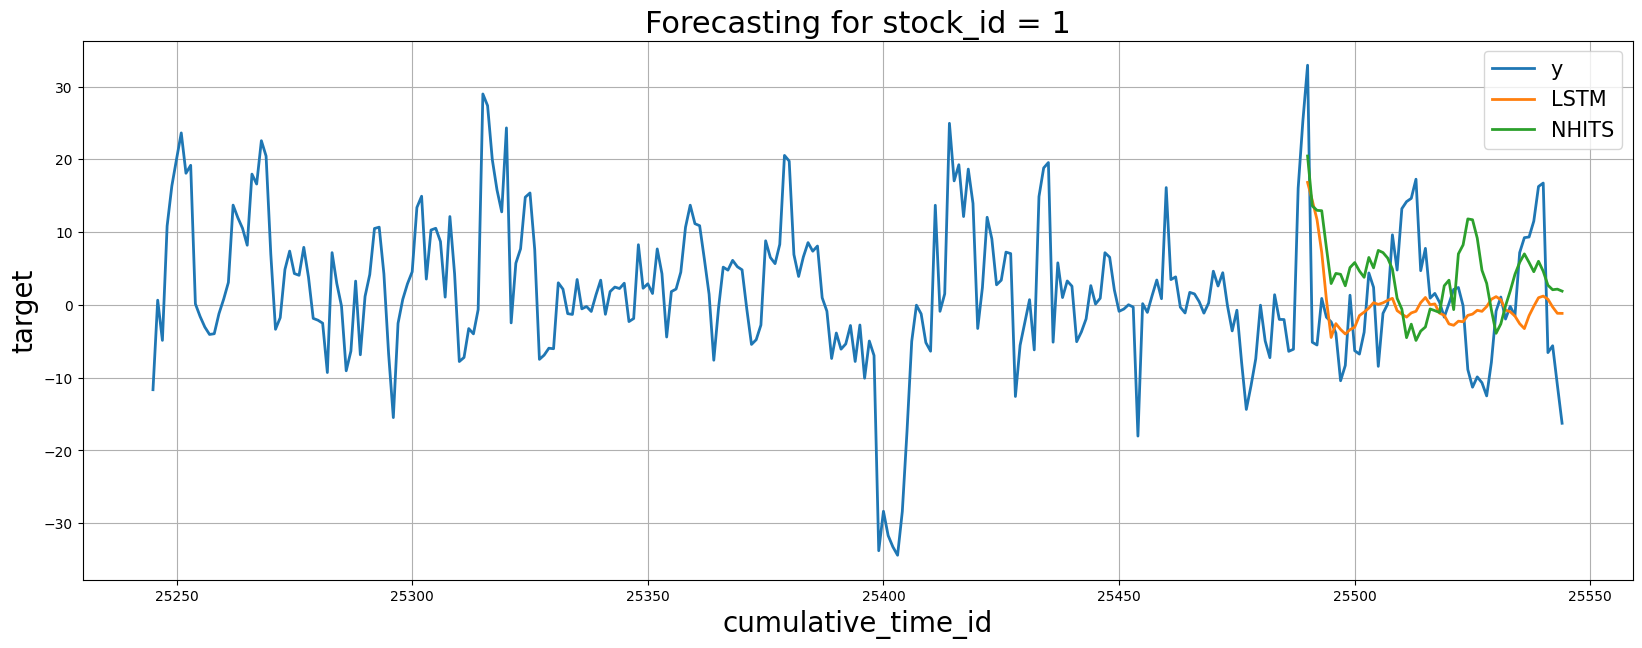

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([Y_df, Y_hat_df]).set_index('ds') # Concatenate the train and forecast dataframes
plot_df[['y', 'LSTM', 'NHITS']].plot(ax=ax, linewidth=2)

ax.set_title('Forecasting for stock_id = 1', fontsize=22)
ax.set_ylabel('target', fontsize=20)
ax.set_xlabel('cumulative_time_id', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()